In [3]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)

In [4]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        #print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        #np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        #np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        #np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 
                          'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 




def LOSOMultiClass(Data,X,y,groups,model,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','RMS'])
    groupres = {} #results on each group for each model
    
    acc_all=[]; acc_train=[] 
    f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
    auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
    RMS_all = []
    
    clf = model[0][0]; model_name = model[0][1]          
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for train_index, test_index in subj.split(X, y, groups):
    #leave one in:
        if LOin:
            tridx = train_index.copy()
            train_index = test_index.copy()
            test_index = tridx
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            #print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        #yscore = clf.predict_proba(Xte)
        #yscore = yscore[:,1]

        #accuracy on train set
        
        RMS=0
        for yp,yt in zip(ypred,y):
            RMS += ((yp - yt)**2)
        RMS = RMS / len(y)
        RMS = math.sqrt(RMS)
        
        RMS_all.append(RMS)
        
        groupres[model_name] = {'RMS':RMS_all}
        
        r = pd.DataFrame({'model':model_name, 'RMS':np.nanmean(RMS_all)},index=[0])
        results = pd.concat((results,r))
        
    return results, groupres

In [10]:
datadict = {'watch':{},'sensor':{}}
for freq in [50,40,30,20,10,7.5,5,3]:
    data = pd.read_csv('Y:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[4:]:
        data = data[data[s]<np.finfo(np.float32).max]
    datadict['watch'][freq] = data[(data.Subject != 1020) & (data.Subject != 1030)].reset_index(drop=True)
for freq in [62.5,60,50,40,30,20,10,7.5,5,3]:
    data = pd.read_csv('Y:CIS-PD Study\\Downsample\\Accel+Gyro Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[4:]:
        data = data[data[s]<np.finfo(np.float32).max]
    datadict['sensor'][freq] = data[(data.Subject != 1020) & (data.Subject != 1030)].reset_index(drop=True)

In [11]:
t1=time.time()
results = {}

for mode in ['watch','sensor']:
    
    results[mode] = {}

    for symptom in ['Tremor','Bradykinesia']:
        
        results[mode][symptom] = {}
        
        results[mode][symptom]['Binary'] = {}
        binary_res_all = pd.DataFrame()
        binary_res_groups = []
        
        results[mode][symptom]['Multiclass'] = {}
        multi_res_all = pd.DataFrame()
        multi_res_groups = pd.DataFrame()
        
        results[mode][symptom]['Regressor'] = {}
        regress_res_all = pd.DataFrame()
        regress_res_groups = pd.DataFrame()

        for freq in datadict[mode].keys():

            data = datadict[mode][freq]
            Data = data.copy() #original unmodified dataframe
            Data=Data[~Data[symptom].isnull()]
            Data=Data.reset_index(drop=True) #reset index

            X = Data.iloc[:,5:].as_matrix()
            fnames = Data.iloc[:,5:].columns.values
            groups = Data.Subject.as_matrix()

            #Binary
            
            y = ((Data[symptom]>0)).values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOCV(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            binary_res_all = pd.concat((binary_res_all,res))
            binary_res_groups.append(res_group)
            
            results[mode][symptom]['Binary']['res_all'] = binary_res_all.reset_index(drop=True)
            results[mode][symptom]['Binary']['res_groups'] = binary_res_groups

            #Multiple Classes

            y = Data[symptom].values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOMultiClass(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            multi_res_groups = pd.concat((multi_res_groups,res))
            R = pd.DataFrame()
            R['RMS'] = [np.nanmean(multi_res_groups[multi_res_groups['Sampling Rate']==(str(freq) + ' Hz')]['RMS'])]
            R['Model'] = ['Random Forest']
            R['Sampling Rate'] = [str(freq) + ' Hz']
            multi_res_all = pd.concat([multi_res_all,R])

            results[mode][symptom]['Multiclass']['res_all'] = multi_res_all.reset_index(drop=True)
            results[mode][symptom]['Multiclass']['res_groups'] = multi_res_groups

            #Regressor

            y = Data[symptom].values.astype(int) #target 

            model = [RandomForestRegressor(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOMultiClass(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            regress_res_groups = pd.concat((regress_res_groups,res))
            R = pd.DataFrame()
            R['RMS'] = [np.nanmean(regress_res_groups[regress_res_groups['Sampling Rate']==(str(freq) + ' Hz')]['RMS'])]
            R['Model'] = ['Random Forest'] 
            R['Sampling Rate'] = [str(freq) + ' Hz']
            regress_res_all = pd.concat([regress_res_all,R])

            results[mode][symptom]['Regressor']['res_all'] = regress_res_all.reset_index(drop=True)
            results[mode][symptom]['Regressor']['res_groups'] = regress_res_groups
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  r

Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  r

Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is il

Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest
Training Random Forest
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars


Training Random Forest
Training Random Forest
Elapsed time = 264.361 min


In [79]:
def barplotFreq(results,mode,symptom,classifier):
    if 'RMS' in results[mode][symptom][classifier]['res_groups']:
        groups = results[mode][symptom][classifier]['res_groups']['Sampling Rate']
        RMS = results[mode][symptom][classifier]['res_groups']['RMS']
        sns.barplot(groups,RMS,ci='sd')
        plt.ylabel('RMS')
        m = results[mode][symptom][classifier]['res_all']['RMS'].max()
        m = math.ceil((m+.01)*20)/20
        plt.ylim([0,m])
    else:
        groups = results[mode][symptom][classifier]['res_all']['Sampling Rate'].values
        aucdf = pd.DataFrame()
        data = results[mode][symptom][classifier]['res_groups']
        for i in range(len(data)):
            aucdf[groups[i]] = data[i]['Random Forest']['auroc']
        sns.barplot(data=aucdf)
        plt.ylabel('AUROC')
        plt.ylim([0,1])
        
    ax = plt.xticks(rotation=90)
    plt.xlabel('Frequency')
    plt.title('Effect of Sampling Frequency on %s Model Performance: %s'%(classifier,symptom))
    
    print(results[mode][symptom][classifier]['res_all'])
    print()

In [94]:
def rmANOVA(results,mode,symptom,classifier):
    df = pd.DataFrame()
    freqlist = list(results[mode][symptom][classifier]['res_all']['Sampling Rate'])
    if 'RMS' in results[mode][symptom][classifier]['res_groups']:
        for freq in freqlist:
            df[freq] = results[mode][symptom][classifier]['res_groups'][results[mode][symptom][classifier]['res_groups']['Sampling Rate']==freq]['RMS']
        df = df.reset_index(drop=True)
    else:
        for i in range(len(freqlist)):
            freq = freqlist[i]
            df[freq] = pd.Series(results[mode][symptom][classifier]['res_groups'][i]['Random Forest']['auroc'])
        df = df[~df['50 Hz'].isnull()].reset_index(drop=True)
    
    grand_mean = np.mean(df.mean())
    sub_means = np.mean(df,axis=1)
    col_means = np.mean(df,axis=0)
    n = len(df)
    k = len(df.columns)
    dftotal = n*k - 1
    dfbw = k - 1
    dfsbj = n - 1
    dfw = dftotal - dfbw
    dferror = dfw - dfsbj
    SSbetween = sum(n*[(m-grand_mean)**2 for m in col_means])
    SSwithin = np.nansum(np.nansum([(df[col] - col_means[i])**2 for i,col in enumerate(df)]))
    SSsubject = sum(k*[(m - grand_mean)**2 for m in sub_means])
    SSerror = SSwithin - SSsubject
    SStotal = SSbetween + SSwithin
    msbetween = SSbetween/dfbw
    mserror = SSerror/dferror
    F = msbetween/mserror
    print('Repeated Measures ANOVA')
    print('p-value: ' + str(stats.f.sf(F,dfbw,dferror)))

           model        f1     auprc     auroc Sampling Rate
0  Random Forest  0.354482  0.497454  0.767256         50 Hz
1  Random Forest  0.348926  0.487468  0.759079         40 Hz
2  Random Forest  0.346192  0.492203  0.744982         30 Hz
3  Random Forest  0.334649  0.477007  0.722293         20 Hz
4  Random Forest  0.234675  0.430888  0.646743         10 Hz
5  Random Forest  0.218836  0.421728  0.645366        7.5 Hz
6  Random Forest  0.222172  0.468251  0.588833          5 Hz
7  Random Forest  0.188207  0.494091  0.609962          3 Hz

Repeated Measures ANOVA
p-value: 6.349822573277802e-07


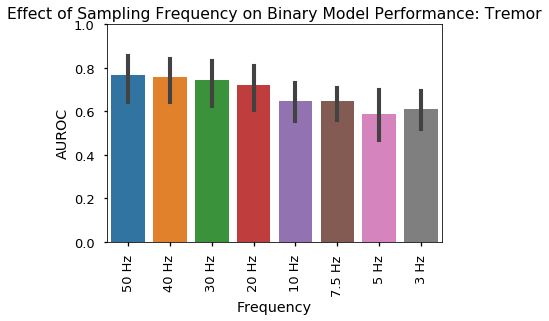

In [80]:
barplotFreq(results,'watch','Tremor','Binary')
rmANOVA(results,'watch','Tremor','Binary')

        RMS          Model Sampling Rate
0  0.132279  Random Forest         50 Hz
1  0.133552  Random Forest         40 Hz
2  0.128480  Random Forest         30 Hz
3  0.122766  Random Forest         20 Hz
4  0.116381  Random Forest         10 Hz
5  0.118392  Random Forest        7.5 Hz
6  0.122850  Random Forest          5 Hz
7  0.115310  Random Forest          3 Hz

Repeated Measures ANOVA
p-value: 1.7537377245154837e-12


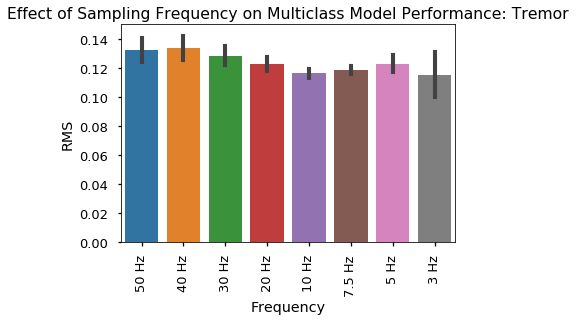

In [81]:
barplotFreq(results,'watch','Tremor','Multiclass')
rmANOVA(results,'watch','Tremor','Multiclass')

        RMS          Model Sampling Rate
0  0.156177  Random Forest         50 Hz
1  0.154171  Random Forest         40 Hz
2  0.154227  Random Forest         30 Hz
3  0.155402  Random Forest         20 Hz
4  0.154948  Random Forest         10 Hz
5  0.157786  Random Forest        7.5 Hz
6  0.161339  Random Forest          5 Hz
7  0.162250  Random Forest          3 Hz

Repeated Measures ANOVA
p-value: 0.0036230258395703575


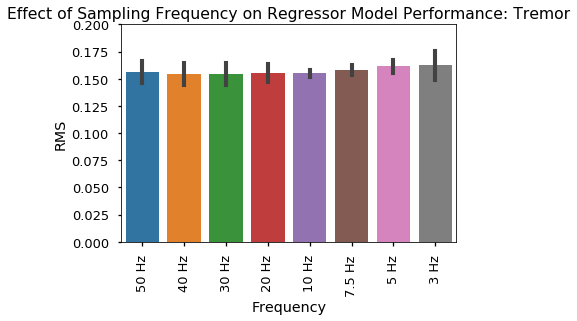

In [82]:
barplotFreq(results,'watch','Tremor','Regressor')
rmANOVA(results,'watch','Tremor','Regressor')

           model        f1     auprc     auroc Sampling Rate
0  Random Forest  0.571449  0.625377  0.632275         50 Hz
1  Random Forest  0.571294  0.619939  0.623462         40 Hz
2  Random Forest  0.577032  0.610341  0.624932         30 Hz
3  Random Forest  0.583184  0.628456  0.640316         20 Hz
4  Random Forest  0.595044  0.615737  0.632721         10 Hz
5  Random Forest  0.593557  0.610719  0.609620        7.5 Hz
6  Random Forest  0.595368  0.617429  0.592839          5 Hz
7  Random Forest  0.562598  0.656285  0.668347          3 Hz

Repeated Measures ANOVA
p-value: 0.5147691814678361


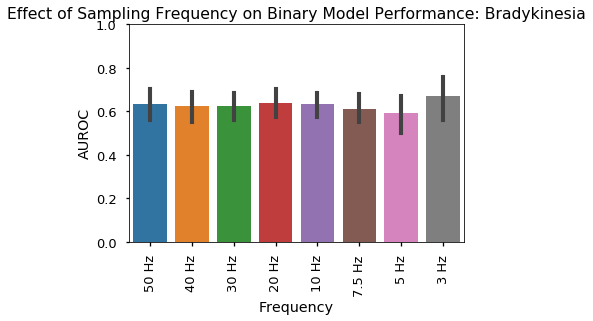

In [83]:
barplotFreq(results,'watch','Bradykinesia','Binary')
rmANOVA(results,'watch','Bradykinesia','Binary')

        RMS          Model Sampling Rate
0  0.242397  Random Forest         50 Hz
1  0.240281  Random Forest         40 Hz
2  0.241651  Random Forest         30 Hz
3  0.237661  Random Forest         20 Hz
4  0.250075  Random Forest         10 Hz
5  0.256932  Random Forest        7.5 Hz
6  0.265058  Random Forest          5 Hz
7  0.250205  Random Forest          3 Hz

Repeated Measures ANOVA
p-value: 4.091764297663831e-09


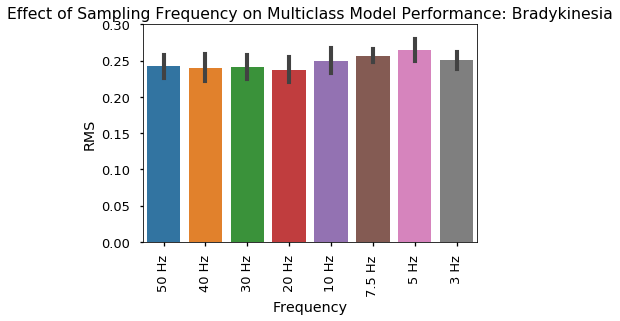

In [84]:
barplotFreq(results,'watch','Bradykinesia','Multiclass')
rmANOVA(results,'watch','Bradykinesia','Multiclass')

        RMS          Model Sampling Rate
0  0.215139  Random Forest         50 Hz
1  0.214557  Random Forest         40 Hz
2  0.214446  Random Forest         30 Hz
3  0.214336  Random Forest         20 Hz
4  0.219014  Random Forest         10 Hz
5  0.227877  Random Forest        7.5 Hz
6  0.234686  Random Forest          5 Hz
7  0.219971  Random Forest          3 Hz

Repeated Measures ANOVA
p-value: 6.490078872493356e-07


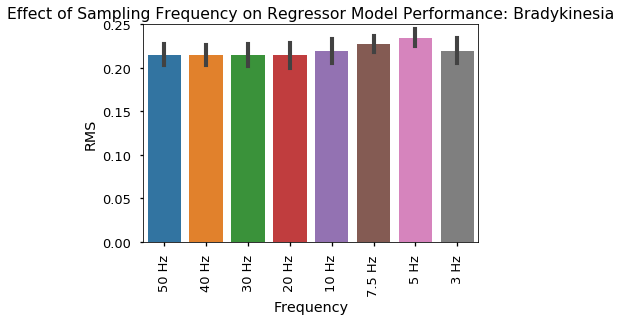

In [85]:
barplotFreq(results,'watch','Bradykinesia','Regressor')
rmANOVA(results,'watch','Bradykinesia','Regressor')

           model        f1     auprc     auroc Sampling Rate
0  Random Forest  0.324566  0.491716  0.709733       62.5 Hz
1  Random Forest  0.329967  0.496894  0.704094         60 Hz
2  Random Forest  0.336064  0.495728  0.702680         50 Hz
3  Random Forest  0.333919  0.498709  0.703870         40 Hz
4  Random Forest  0.325345  0.495372  0.700422         30 Hz
5  Random Forest  0.307176  0.492140  0.682134         20 Hz
6  Random Forest  0.222547  0.457176  0.626877         10 Hz
7  Random Forest  0.193649  0.464832  0.629483        7.5 Hz
8  Random Forest  0.171551  0.498918  0.604705          5 Hz
9  Random Forest  0.214382  0.520873  0.549859          3 Hz

Repeated Measures ANOVA
p-value: 3.2767912442163376e-07


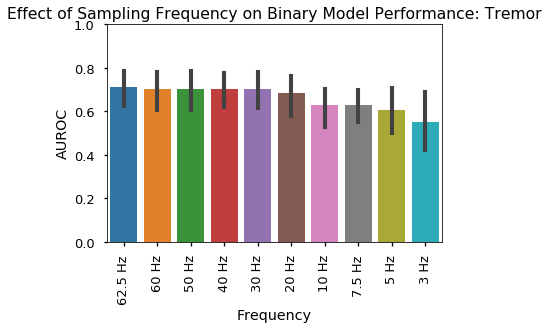

In [86]:
barplotFreq(results,'sensor','Tremor','Binary')
rmANOVA(results,'sensor','Tremor','Binary')

        RMS          Model Sampling Rate
0  0.125522  Random Forest       62.5 Hz
1  0.123240  Random Forest         60 Hz
2  0.124672  Random Forest         50 Hz
3  0.122301  Random Forest         40 Hz
4  0.122155  Random Forest         30 Hz
5  0.120190  Random Forest         20 Hz
6  0.116276  Random Forest         10 Hz
7  0.128305  Random Forest        7.5 Hz
8  0.128084  Random Forest          5 Hz
9  0.154236  Random Forest          3 Hz

Repeated Measures ANOVA
p-value: 1.064141508409497e-25


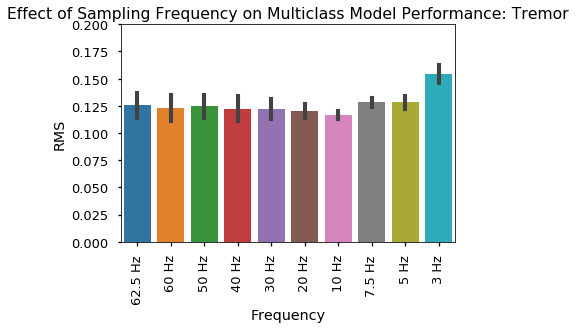

In [87]:
barplotFreq(results,'sensor','Tremor','Multiclass')
rmANOVA(results,'sensor','Tremor','Multiclass')

        RMS          Model Sampling Rate
0  0.146839  Random Forest       62.5 Hz
1  0.147118  Random Forest         60 Hz
2  0.146836  Random Forest         50 Hz
3  0.147624  Random Forest         40 Hz
4  0.150726  Random Forest         30 Hz
5  0.155723  Random Forest         20 Hz
6  0.158309  Random Forest         10 Hz
7  0.162668  Random Forest        7.5 Hz
8  0.163697  Random Forest          5 Hz
9  0.162935  Random Forest          3 Hz

Repeated Measures ANOVA
p-value: 2.6676716575639016e-19


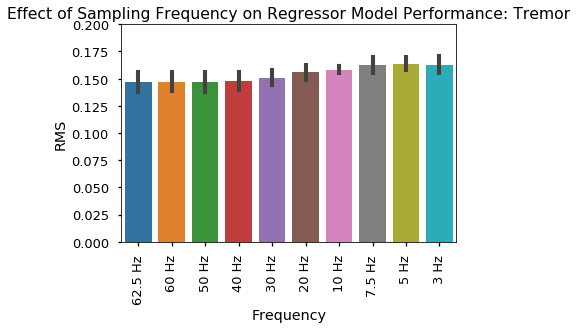

In [89]:
barplotFreq(results,'sensor','Tremor','Regressor')
rmANOVA(results,'sensor','Tremor','Regressor')

           model        f1     auprc     auroc Sampling Rate
0  Random Forest  0.603114  0.627671  0.663175       62.5 Hz
1  Random Forest  0.596175  0.621225  0.649503         60 Hz
2  Random Forest  0.598423  0.625046  0.652351         50 Hz
3  Random Forest  0.592920  0.618806  0.644091         40 Hz
4  Random Forest  0.599298  0.622878  0.656030         30 Hz
5  Random Forest  0.593429  0.620909  0.648170         20 Hz
6  Random Forest  0.603780  0.618991  0.637837         10 Hz
7  Random Forest  0.612921  0.642692  0.646587        7.5 Hz
8  Random Forest  0.561250  0.587812  0.599761          5 Hz
9  Random Forest  0.545182  0.695860  0.682190          3 Hz

Repeated Measures ANOVA
p-value: 0.13880487679067038


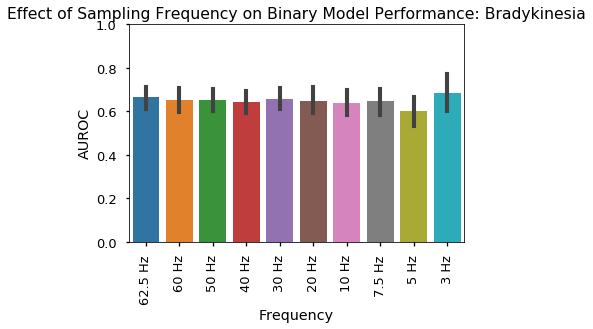

In [91]:
barplotFreq(results,'sensor','Bradykinesia','Binary')
rmANOVA(results,'sensor','Bradykinesia','Binary')

        RMS          Model Sampling Rate
0  0.240603  Random Forest       62.5 Hz
1  0.238682  Random Forest         60 Hz
2  0.237946  Random Forest         50 Hz
3  0.238152  Random Forest         40 Hz
4  0.240221  Random Forest         30 Hz
5  0.235078  Random Forest         20 Hz
6  0.250628  Random Forest         10 Hz
7  0.263025  Random Forest        7.5 Hz
8  0.260720  Random Forest          5 Hz
9  0.237948  Random Forest          3 Hz

Repeated Measures ANOVA
p-value: 1.5027425851390103e-28


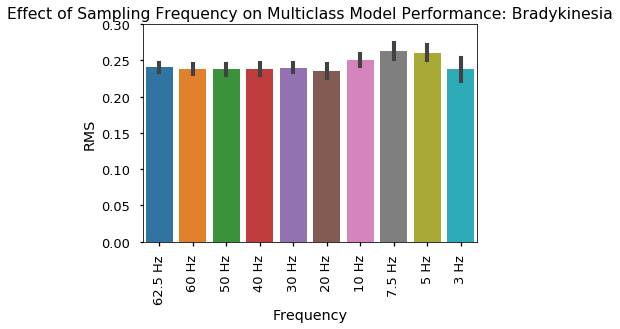

In [92]:
barplotFreq(results,'sensor','Bradykinesia','Multiclass')
rmANOVA(results,'sensor','Bradykinesia','Multiclass')

        RMS          Model Sampling Rate
0  0.221934  Random Forest       62.5 Hz
1  0.223297  Random Forest         60 Hz
2  0.222046  Random Forest         50 Hz
3  0.224521  Random Forest         40 Hz
4  0.222019  Random Forest         30 Hz
5  0.222975  Random Forest         20 Hz
6  0.228159  Random Forest         10 Hz
7  0.234287  Random Forest        7.5 Hz
8  0.228661  Random Forest          5 Hz
9  0.196725  Random Forest          3 Hz

Repeated Measures ANOVA
p-value: 4.458676529645024e-36


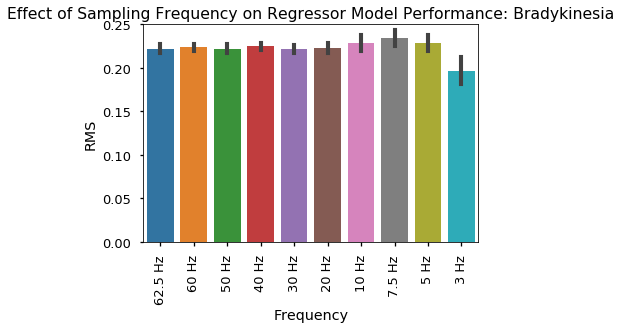

In [93]:
barplotFreq(results,'sensor','Bradykinesia','Regressor')
rmANOVA(results,'sensor','Bradykinesia','Regressor')